In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement= Base.classes.measurement
Station= Base.classes.station

In [9]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [10]:
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


mindate = session.query(Measurement.date).order_by(Measurement.date).first()
maxdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f" Least date available: {mindate[0]} , Latest date available: {maxdate[0]}")


# Calculate the date 1 year ago from the last data point in the database

strip_last_date=dt.datetime.strptime(maxdate[0], '%Y-%m-%d')
one_year_past_date=dt.date(strip_last_date.year -1, strip_last_date.month, strip_last_date.day)
print(f" Date 1 year ago from the last date in the database is {one_year_past_date}")
   

 Least date available: 2010-01-01 , Latest date available: 2017-08-23
 Date 1 year ago from the last date in the database is 2016-08-23


In [15]:
   
# Perform a query to retrieve the data and precipitation scores
prcp_results=session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= one_year_past_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results, columns=[ 'Date','Precipitation'])
prcp_df.dropna(how='any') # clean up non value entries
prcp_df.set_index('Date', inplace=True, )

# Sort the dataframe by date
#Setting date as index sorted the dataframe already
prcp_df.head(10)



,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


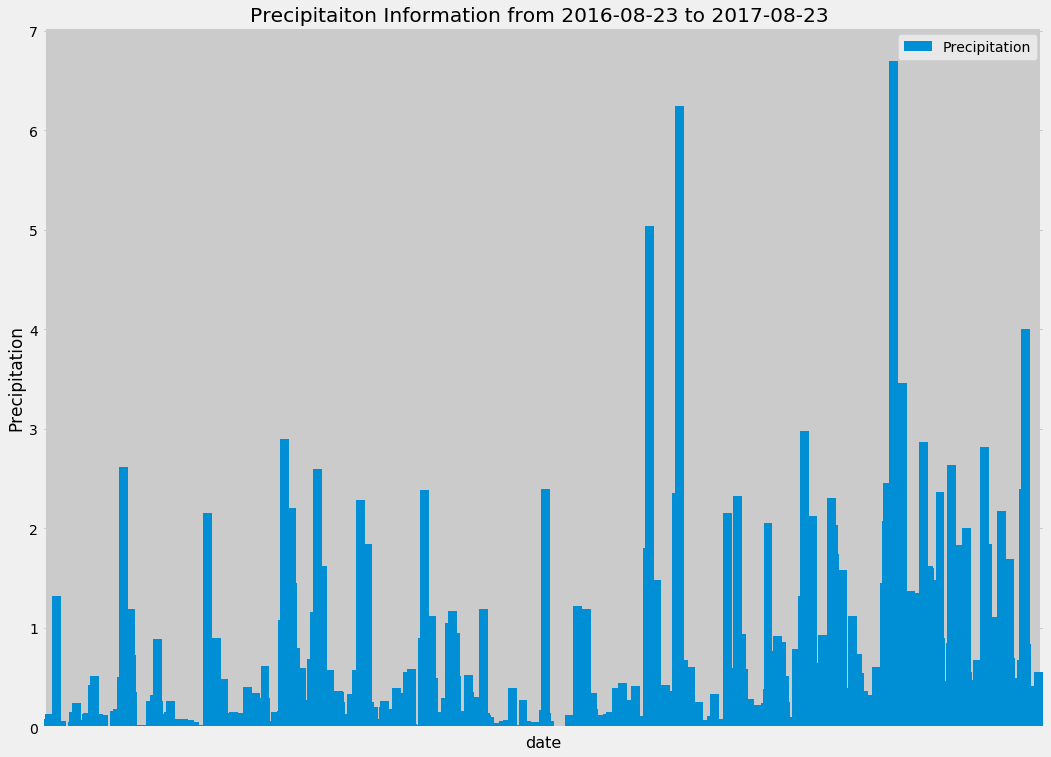

<Figure size 432x288 with 0 Axes>

In [30]:

#plt.figure(figsize=(10,7))
ax= prcp_df.plot.bar(figsize=(16,12), width=20,rot=45)
ax.set_xlabel("date", fontsize=16)
ax.set_xticklabels([])
plt.title(f"Precipitaiton Information from {one_year_past_date} to {maxdate[0]} ")
ax.set_ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.show()

plt.savefig('Images/precipitation.png')

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.id).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_act_station=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.id).desc()).first()
most_act_station

(54.0, 85.0, 71.66378066378067)

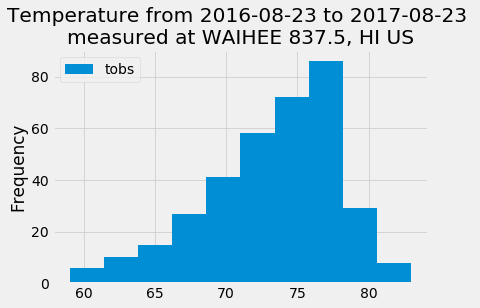

In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp_obs = session.query(Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).\
    filter(Measurement.date >= one_year_past_date).all()
temperature_list = list(np.ravel(high_temp_obs))

station_desc = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all()
station_df = pd.DataFrame(station_desc, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = station_df.loc[station_df["Station"] == active_stations[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperature_list,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {one_year_past_date} to {maxdate[0]} \nmeasured at {station_name}")
plt.legend()
plt.savefig('Images/station_histogram.png',orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches='tight')


## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2017-07-01'
enddate = '2017-07-15'
#temp_rslt = calc_temps(startdate,enddate)[0]
tmin, tavg, tmax= calc_temps(startdate,enddate)[0]
print(tmin, tavg, tmax)

69.0 78.25 87.0


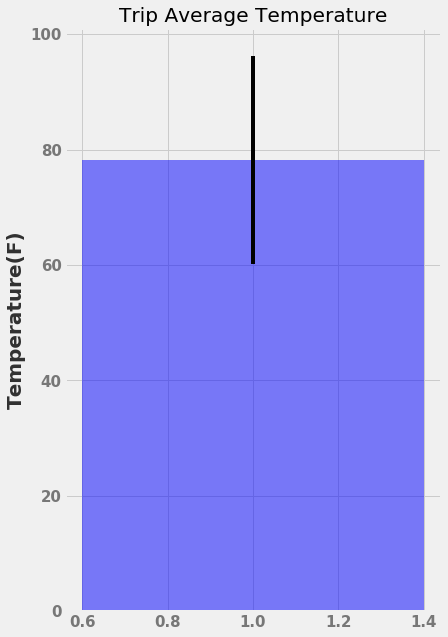

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#t_df = pd.DataFrame(temp_rslt, columns=["tmin", "tavg", "tmax"])
peak_to_peak=tmax-tmin

# plot the average temp 
plt.figure(figsize=[6,10])
plt.bar(1,tavg,yerr=peak_to_peak, align='center',alpha=0.5,color='blue')

plt.ylabel('Temperature(F)', fontweight="bold", alpha=0.8, fontsize=20)
plt.xticks(fontweight="bold", alpha=0.5, fontsize=15)
plt.yticks(fontweight="bold", alpha=0.5, fontsize=15)
plt.title('Trip Average Temperature')
plt.show()
plt.savefig('Images/temperature.png')


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

startdate = '2017-07-01'
enddate = '2017-07-15'

rainfall_result = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
                filter(Station.station == Measurement.station).\
                group_by(Measurement.station).\
                filter(Measurement.date >= startdate).\
                filter(Measurement.date <= enddate).\
                order_by(func.sum(Measurement.prcp).desc()).\
                all()
  
rainfall_station_df = pd.DataFrame(rainfall_result, columns=['Station','Name','Latitude','Longitude','Elevation','TotalPrcp'])
rainfall_station_df

,Station,Name,Latitude,Longitude,Elevation,TotalPrcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.87
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.64
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.83
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.39
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.21
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.13
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startdate = '2018-01-01'
enddate = '2018-01-07'

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings
startdtobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(enddate, '%Y-%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_dates = []
normals =[]
while (startdtobj <= enddtobj):
    trip_dates.append(dt.datetime.strftime(startdtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(startdtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    startdtobj = startdtobj + dt.timedelta(days = 1)

normals


[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0]]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
daily_normals_df['Date'] = trip_dates
daily_normals_df = daily_normals_df.set_index("Date")
daily_normals_df

,tmin,tavg,tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


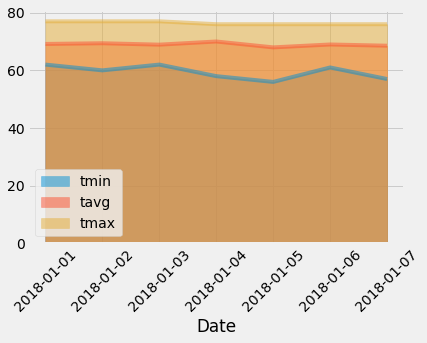

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.savefig('Images/daily_normals.png',orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches='tight')